In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

mnist_data = datasets.MNIST('data', train = True, download = True,
                           transform = transforms.ToTensor())
mnist_data = list(mnist_data)[:4096]

from resnet_classes import *

In [75]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder, *args, **kwargs):
        super(Autoencoder, self).__init__(*args, **kwargs)
        self.encoder, self.decoder = encoder, decoder
    
    def forward(self, X):
        X = self.encoder(X)
        X = self.decoder(X)
        return X
    
class Encoder(nn.Module):
    def __init__(self, layers, *args, **kwargs):
        super(Encoder, self).__init__(*args, **kwargs)
        self.encoder = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.encoder(x)
    
class Decoder(nn.Module):
    def __init__(self, layers, *args, **kwargs):
        super(Decoder, self).__init__(*args, **kwargs)
        self.decoder = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.decoder(x)
    
class Upsampling(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Upsampling, self).__init__(*args, **kwargs)
    
    def forward(self, x):
        return F.interpolate(x, scale_factor = 2, mode = 'nearest')

In [94]:
ngpu = 1
batch_size = 8
torch.manual_seed(42)
train_loader = torch.utils.data.DataLoader(mnist_data,
                                            batch_size = batch_size,
                                            shuffle = True)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [96]:
def train(model, loader, num_epochs = 5, batch_size = 64, learning_rate = 1e-3):
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr = learning_rate,
                                 weight_decay = 1e-5)
    criterion = nn.MSELoss()
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            img = img.to(device)
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
        del(img)
    
    return outputs

In [126]:
resnetEncoderLayers = Encoder([
    ResNetLayer(1, 64, n = 5),
    ResNetLayer(64, 128, n = 5)
])
resnetDecoderLayers = Decoder([
    Upsampling(),
    ResNetBasicBlock(128, 64),
    Upsampling(),
    ResNetBasicBlock(64, 1)
])

ResnetAutoencoder = Autoencoder(resnetEncoderLayers, resnetDecoderLayers).to(device)

In [127]:
max_epochs = 30
outputs = train(ResnetAutoencoder, train_loader, num_epochs = max_epochs)

Epoch:1, Loss:0.0044
Epoch:2, Loss:0.0022
Epoch:3, Loss:0.0026
Epoch:4, Loss:0.0020
Epoch:5, Loss:0.0012
Epoch:6, Loss:0.0015
Epoch:7, Loss:0.0012
Epoch:8, Loss:0.0011
Epoch:9, Loss:0.0011
Epoch:10, Loss:0.0008
Epoch:11, Loss:0.0008
Epoch:12, Loss:0.0006
Epoch:13, Loss:0.0008
Epoch:14, Loss:0.0008
Epoch:15, Loss:0.0005
Epoch:16, Loss:0.0004
Epoch:17, Loss:0.0006
Epoch:18, Loss:0.0005
Epoch:19, Loss:0.0005
Epoch:20, Loss:0.0004
Epoch:21, Loss:0.0005
Epoch:22, Loss:0.0004
Epoch:23, Loss:0.0009
Epoch:24, Loss:0.0004
Epoch:25, Loss:0.0003
Epoch:26, Loss:0.0003
Epoch:27, Loss:0.0003
Epoch:28, Loss:0.0005
Epoch:29, Loss:0.0003
Epoch:30, Loss:0.0003


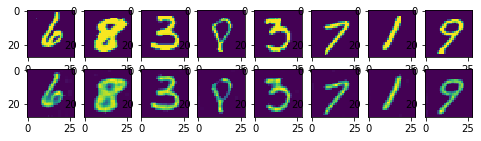

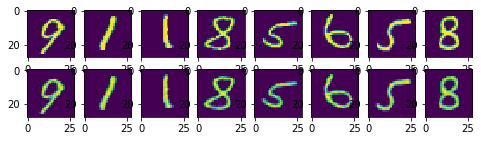

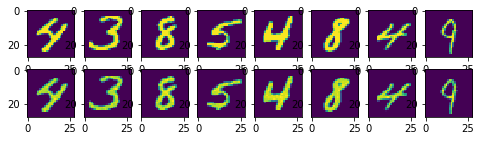

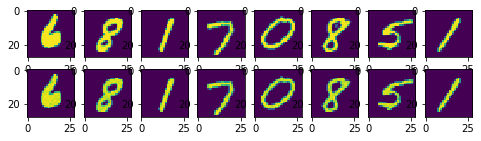

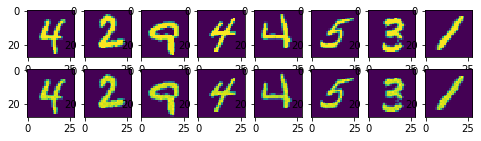

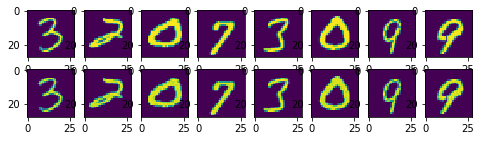

In [128]:
for k in range(0, max_epochs, 5):
    plt.figure(figsize = (9, 2))
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

***

In [130]:
# %run "Scripts/dataprep.py"
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('C:\\Users\\Patrick\\Documents\\GitHub\\ICDeepLearning\\Codigos\\Análise de BCI\\Scripts')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, models
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from utils import *
from SSVEPDataset import SSVEPDataset
from classes import *
from SSVEPDataloader import *

from sklearn import preprocessing
import os
import time
import copy
from functools import partial

def read_data(dataframe):
    return torch.tensor(pd.read_csv(dataframe['path'], sep = ' ', header = None, dtype = float).values)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [252]:
def dataVisualization(X):
    X = X.squeeze().T
    
    fig = plt.figure(figsize = (20, 20))
    ax = fig.add_subplot()
    ax.imshow(X, cmap = 'gray')

In [132]:
dataType = '512'
path = 'C:\\Users\\Patrick\\Documents\\GitHub\\ICDeepLearning\\Codigos\\Análise de BCI\\'
data = pd.read_csv(path+'SSVEPDataset_'+dataType+'.csv')
dataset = SSVEPDataset(data)

batchSize = 4
dataloaders, datasetsSizes = SSVEPDataloaders(dataset, batchSize)
# example = next(iter(dataloaders['train']))['series']

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
# device = 'cpu'

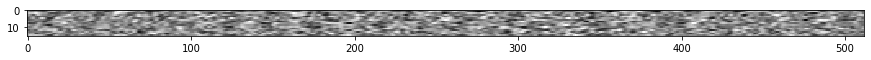

In [230]:
exemplo = iter(dataloaders['train']).next()['series'].type(torch.float32)
stage = iter(dataloaders['train']).next()['class']
dataVisualization(exemplo[0])

In [231]:
exemplo.dtype

torch.float32

In [169]:
# block = ResNetBasicBlock(1, 1)
block = ResNetLayer(1, 1, n = 5)
block(exemplo).shape

torch.Size([4, 1, 512, 16])

In [217]:
class ResNetAltBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv = self.conv, bias = False,
                    stride = (self.downsampling, 1)),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv = self.conv, bias = False)
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size = 1,
                     stride = (self.downsampling, 1), bias = False),
            nn.BatchNorm2d(self.expanded_channels)
        ) if self.should_apply_shortcut else None
        
class ResNetAltLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block = ResNetAltBlock, n = 1, *args, **kwargs):
        super().__init__()
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels, out_channels, *args, **kwargs, downsampling = downsampling),
            *[block(out_channels * block.expansion,
                    out_channels, downsampling = 1, *args, **kwargs) for _ in range(n - 1)]
        )
        
    def forward(self, x):
        x = self.blocks(x)
        return x
    
class UnilateralUpsampling(nn.Module):
    def __init__(self, *args, **kwargs):
        super(UnilateralUpsampling, self).__init__(*args, **kwargs)
    
    def forward(self, x):
        return F.interpolate(x, scale_factor = (2, 1), mode = 'nearest')

In [232]:
# ** Training algorithms

def train(model, dataloaders, criterion, optimizer, scheduler, device,
          num_epochs = 25, learningRate = 1e-2, temp = 0):
    since = time.time()
    bestModel = copy.deepcopy(model.state_dict())
    bestLoss = np.inf
    
    trainLoss = []
    validLoss = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and a validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            runningLoss = 0.0
            runningCorrects = 0
            
            for sample in dataloaders[phase]:
                inputs = sample['series'].type(torch.float32).to(device)
                labels = sample['class'].to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if temp == 0:
                        loss = criterion(outputs, inputs)
                    else:
                        loss = criterion(outputs, labels)
                    
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                runningLoss += loss.item() * inputs.size(0)
                del(inputs); del(labels)
                
            if phase == 'train':
                scheduler.step()
                
            epochLoss = runningLoss/datasetsSizes[phase]
            
            if phase == 'train':
                trainLoss.append(epochLoss)
            else:
                validLoss.append(epochLoss)
            
            print('{} Loss: {:.4f}'.format(phase, epochLoss))
            
            if phase == 'val' and epochLoss < bestLoss:
                bestLoss = epochLoss
                bestModel = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(bestLoss))
    
    model.load_state_dict(bestModel)
    return model, [trainLoss, validLoss], bestLoss

In [209]:
layer = ResNetAltLayer(1, 3)
layer2 = ResNetAltLayer(3, 4)

In [213]:
block = ResNetAltBlock(1, 3)
block(exemplo).shape

torch.Size([4, 3, 512, 16])

In [210]:
layer2(layer(exemplo)).shape

torch.Size([4, 4, 128, 16])

In [219]:
resnetEncoderLayers = Encoder([
    ResNetAltLayer(1, 16, n = 4),   # 512 -> 256
    ResNetAltLayer(16, 32, n = 4),  # 256 -> 128
    ResNetAltLayer(32, 64, n = 4),  # 128 -> 64
    ResNetAltLayer(64, 128, n = 4), # 64  -> 32
    ResNetAltLayer(128, 256, n = 4),# 32  -> 16
])
resnetDecoderLayers = Decoder([
    UnilateralUpsampling(), # 16  -> 32
    ResNetAltBlock(256, 128),
    UnilateralUpsampling(), # 32  -> 64
    ResNetAltBlock(128, 64),
    UnilateralUpsampling(), # 64  -> 128
    ResNetAltBlock(64, 32),
    UnilateralUpsampling(), # 128 -> 256
    ResNetAltBlock(32, 16),
    UnilateralUpsampling(), # 256 -> 512
    ResNetAltBlock(16, 1)
])

ResnetAutoencoder = Autoencoder(resnetEncoderLayers, resnetDecoderLayers).to(device)

In [222]:
optimizer = optim.Adam(ResnetAutoencoder.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

In [233]:
criterion = nn.MSELoss()
ResnetAutoencoder, stats, bestLoss = train(ResnetAutoencoder, dataloaders, criterion, optimizer, scheduler, device,
                         num_epochs = 5)

Epoch 0/4
----------
train Loss: 0.1142
val Loss: 0.1128

Epoch 1/4
----------
train Loss: 0.1031
val Loss: 0.0830

Epoch 2/4
----------
train Loss: 0.0778
val Loss: 0.0836

Epoch 3/4
----------
train Loss: 0.0720
val Loss: 0.0726

Epoch 4/4
----------
train Loss: 0.0679
val Loss: 0.0670

Training complete in 5m 18s
Best val Loss: 0.067049


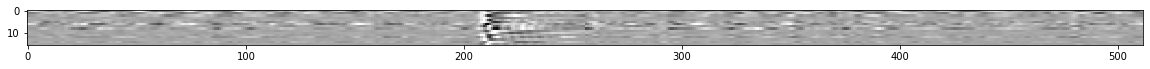

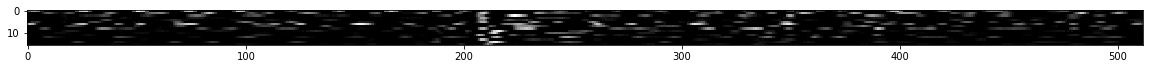

In [260]:
exemplo = iter(dataloaders['train']).next()['series'].type(torch.float32)
stage = iter(dataloaders['train']).next()['class']
dataVisualization(*exemplo[0])
dataVisualization(ResnetAutoencoder(exemplo.to(device))[0].cpu().detach().numpy())

In [241]:
ResnetAutoencoder.encoder(exemplo.to(device))[0].cpu().detach().numpy()

(256, 16, 16)